In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# %matplotlib inline
# plt.rcParams["figure.figsize"] = [14, 7]
# plt.rcParams["font.size"] = 14
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False
# plt.rcParams["axes.facecolor"] = "WhiteSmoke"

# 使用自定义的函数来直接设置图片格式
import sys
sys.path.append("../d2l_func/")
from utils import *

# 自定义的设置图片的函数
set_fig_display()
# 设置字体
# plt.rcParams["font.sans-serif"] = ["SimHei"]

线性回归和softmax回归等都可以看成是单层的神经网络
- 神经网络并不等价于深度学习，深度学习还包括一些概率图模型，但目前深度学习基本使用的都是神经网络
    - 这是因为模型是深层的原因，存在着贡献度分配问题，而BP算法比较有效地解决了这个问题
- 线性回归是回归问题（输出是连续数值），softmax回归是分类问题（输出是离散数值）

# 线性回归

- 线性回归的模型，其中w是权重，b是偏置项 
$$y = w^Tx + b$$
- 损失函数（用于衡量误差的函数，机器学习中主要优化的部分），线性回归主要使用的平方损失
$$L = \frac{1}{2n}\sum_{i=1}^n(y_i - w^Tx_i - b)^2$$
我们希望获得是的训练样本平均损失最小的函数：
$$\hat w, \hat b = \underset{w, b}{\arg min}L(w, b)$$
求偏导数得到
$$\frac{\partial L(w, b)}{\partial w} = \frac{1}{n}\sum_{i=1}^nx_i(w^Tx_i + b -y_i)$$
$$\frac{\partial L(w, b)}{\partial b} = \frac{1}{n}\sum_{i=1}^n(w^Tx_i + b -y_i)$$

## 数据生成

使用书上的权重和偏置项的值
- $w = [2, -3.4]^T$
- $b = 4.2$

添加一个均值为0，标准差为0.01的正态分布，$\varepsilon \sim N(0, 0.01)$<br/>
最后获得模型：
$$y = w^Tx + b + \varepsilon$$

(10000, 2)
(10000,)


Text(0.5, 0, '第1特征的数据')

Text(0, 0.5, '模型输出')

Text(0.5, 0, '第2特征的数据')

Text(0.5, 1.0, '线性回归模型图')

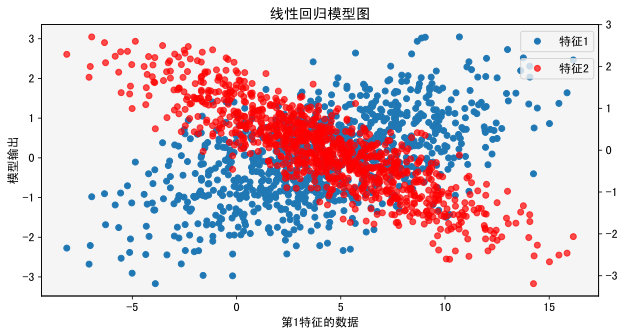

In [4]:
# 生成一些数据用于测试
# 数据量
input_num = 10000

# 模型参数
w = np.array([2, -3.4])
b = np.array([4.2])

# 随机项
error = np.random.normal(0, 0.01, size = input_num)

# 模型数据
x = np.random.normal(0, 1, size = (input_num, len(w)))
y = x@w + b + error

print(x.shape)
print(y.shape)
# 画图（使用维度1/维度2分两侧来进行画图）
# 点太多，先随机采样选取一部分点来画图
sample_index = np.random.choice(len(y), 1000, replace=False)
set_fig_display(pic_format="png", axes_spines_state=[True]*4)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
ax1.plot(y[sample_index], x[sample_index, 0], "o", label = "特征1")
ax1.set_xlabel("第1特征的数据")
ax1.set_ylabel("模型输出")
ax1.legend(loc=(0.86, 0.9))

ax2 = ax1.twinx()
ax2.plot(y[sample_index], x[sample_index, 1], "ro", label = "特征2", alpha=0.7)
ax2.set_xlabel("第2特征的数据")
# 设置标题
plt.title("线性回归模型图")
ax2.legend(loc=(0.86, 0.8))

## 正规方程组实现

为了方便起见，将w记为(w, b)，则线性模型可以记为
$$y = w^Tx$$

对L求偏导数可以获得，最优的参数$w = (X^TX)^{-1}X^TY$（使用的最小二乘法）

In [5]:
# 将输入变成设计矩阵
x_b = np.ones([y.shape[0], 1])
# 其中r_相当于vstack，但是要求有相同的维度，即需要将(1000,)转化为(1, 1000)，而vstack不需要
# 同理c_和hstack类似
X = np.hstack((x_b, x))
X

array([[ 1.        ,  0.73448276,  0.58469555],
       [ 1.        ,  0.03957998, -0.06210955],
       [ 1.        ,  0.00564048,  0.82309259],
       ...,
       [ 1.        ,  0.46702767,  0.48064454],
       [ 1.        ,  0.68452117, -0.1542097 ],
       [ 1.        , -1.33965877, -2.23333582]])

In [6]:
# 使用正规方程组来实现
wb = np.linalg.inv(X.T@X)@X.T@y
# 原始的权重为[4.2, 2, -3.4]<--(b, w)
wb

array([ 4.19990828,  2.00010978, -3.40015512])

当数据量较少时，使用正规方程组求解是可行的（特征小于1000时），但是当数据量较大时，使用正规方程组的速度较慢，此时应使用梯度下降等优化方法
- 尤其是当特征数大于数据量时，由于设计矩阵不可逆，这是难以使用正规方程求解，可以使用梯度下降来代替

当特征和数量较少时，使用正规方程组来求解速度还比较快
- 但是正规方程组需要考虑帽子矩阵中不可逆的情况（存在多重共线的情况），此时需要先降维

## 使用梯度下降实现

当特征和数量很多时，使用梯度下降要比使用正规方程组要有效得多，而且也能规避帽子矩阵不可逆的情况
- 但是使用梯度下降不一定可以得到全局最优，尤其对于非凸函数往往只能获取局部最优

### 梯度下降算法描述

In [7]:
def data_iter(batch_size, feature, label):
    """
    功能：将数据集划分为多个batch
    参数 batch_size：每个batch的大小
    参数 feature：输入数据x
    参数 label：标签数据
    """
    # 训练数据的规模
    data_num = len(label)
    
    # 使用索引来进行随机抽取一个batch的数据
    index = np.arange(data_num)
    np.random.shuffle(index)
    
    for i in range(0, data_num, batch_size):
        up_index = np.minimum(i + batch_size, data_num)
        yield feature[i:up_index], label[i:up_index]

In [8]:
batch_size = 10
for xdata, ydata in data_iter(batch_size, X, y):
    print(xdata)
    print(ydata)
    break

[[ 1.          0.73448276  0.58469555]
 [ 1.          0.03957998 -0.06210955]
 [ 1.          0.00564048  0.82309259]
 [ 1.          0.19235756 -1.41044842]
 [ 1.          0.92612462  0.9563968 ]
 [ 1.          2.07086781  1.56039598]
 [ 1.         -0.75637681  0.24153999]
 [ 1.         -0.19181795 -0.32528972]
 [ 1.          0.67566165  0.62140747]
 [ 1.          0.84322188  1.37331979]]
[3.69107339 4.49033164 1.42730539 9.37674212 2.79258726 3.0404418
 1.8671032  4.921504   3.43374446 1.20736753]


In [9]:
class linear_model(object):
    def __init__(self, alpha=0.01):
        self.w = None
        self.b = 0
        self.alpha = alpha
        self.count = 0

    def linreg(self, X):
        return X@self.w + self.b

    def fit(self, X, y):
        # 初始化参数
        fea_num = int(X.size / len(y))
        if self.count == 0:
            self.w = np.zeros(fea_num)

        # 值预测
        X = X.reshape(len(y), fea_num)
        y = y.reshape(-1)
        y_pred = self.linreg(X)

        # 梯度下降
        self.w -= self.alpha*(X.T@(y_pred - y))/len(y)
        self.b -= self.alpha*(y_pred - y).sum()/len(y)
        self.count += 1

    def predict(self, X):
        y_pred = self.linreg(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        mse = ((y_pred - y)**2).sum()/len(y)
        return mse

In [10]:
import sys


class sqdm(object):
    """
    功能：显示进度条+即时的mse更新
    属性 bar_length：进度条长度
    属性 iter_num：迭代次数
    """

    def __init__(self):
        self.bar_length = 70
        self.iter_num = 0

    def show_process(self, data_num, batch_size, mse):
        # 更新属性
        self.iter_num = np.minimum(self.iter_num + batch_size, data_num)
        
        # 当前进度
        percent = int(self.iter_num/data_num*100)
        num_arrow = int(percent/100*self.bar_length)
        num_bash = self.bar_length - num_arrow

        # 显示进度条
        epoch_bar = f"{self.iter_num}/{data_num} " + "[" + ">"*num_arrow + \
            "-"*num_bash + "]" + " - " + "loss: " + str(mse) + "\r"
        # 输出到标准输出流
        sys.stdout.write(epoch_bar)
        # 把缓冲区的数据刷出来
        sys.stdout.flush()
        
        # 循环完一轮后更新参数
        if self.iter_num == data_num:
            self.iter_num = 0

In [11]:
import time

param = {
    "model": linear_model(),
    "epoch_num": 10,
    "batch_size": 128
}

process_bar = sqdm()

def train(model, epoch_num, batch_size):
    for epoch in range(epoch_num):
        print(f"Epoch {epoch+1}/{epoch_num}")
        for xdata, ydata in data_iter(batch_size, x, y):
            model.fit(xdata, ydata)
            mse = np.round(model.score(xdata, ydata), 5)
            process_bar.show_process(len(y), batch_size, mse)
#             time.sleep(0.01)
        print("\n")
        
    return model
            
# 训练
model = train(**param)

# 权重显示
print(f"训练后的w权重{model.w}，原始的w权重[2, -3.4]")
print(f"训练后的b权重{model.b}，原始的b权重[4.2]")

Epoch 1/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 6.95385

Epoch 2/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 1.38932

Epoch 3/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.27746

Epoch 4/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.05529

Epoch 5/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.01097

Epoch 6/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00218

Epoch 7/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00046

Epoch 8/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00013

Epoch 9/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 

## pytorch从零实现

In [12]:
import torch
from torch.autograd import Variable

In [13]:
input_num = 10000
w = torch.tensor([2, -3.4])
b = torch.tensor([4.2])

x = torch.normal(mean = 0, std = 1, size = (input_num, len(w)))
error = torch.normal(mean = 0, std = 0.01, size = (input_num, ))
y = torch.mv(x, w) + b + error

In [14]:
def linreg(w, x, b):
    return torch.mv(x, w) + b

torch的broadcast和运算时对于矩阵的维度要明确，不然很容易boradcast错

对于nn.MSELoss，pytorch在实现的时候并没有除以$\frac{1}{2}$，但是有没有常数项其实影响不大，这里根据以下公式来编写`square_loss`，动手深度学习中并没有除以N（即batch_size），pytorch中默认是选择`mean`模式来计算MSELoss
$$L = \frac{1}{2N} \sum_{i=1}^N(\hat y - y)^2$$
实际上不除以$\frac{1}{2}$的更新更快

In [15]:
def square_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape))**2).sum()/(2*len(y))

In [16]:
import torch.nn as nn

# 验证nn.MSELoss和个人实现
loss = nn.MSELoss()
loss(torch.tensor([1, 2, 3], dtype = torch.float), torch.tensor([2, 3, 1], dtype = torch.float))

square_loss(torch.tensor([1, 2, 3], dtype = torch.float), torch.tensor([2, 3, 1], dtype = torch.float))

tensor(2.)

tensor(1.)

In [17]:
# 实现sgd
def sgd(params, lr):
    for param in params:
        # 更改param时使用param.data
        param.data -= lr * param.grad

In [18]:
params = {
    "lr": 0.01,
    "batch_size": 128,
    "epoch_num": 10,
    "net": linreg,
    "loss": square_loss,
}

# 初始化权重和偏置项
w = torch.normal(0, 0.01, size=(2, ), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

def train(net, loss, lr, batch_size, epoch_num):
    for epoch in range(epoch_num):
        print(f"Epoch {epoch+1}/{epoch_num}")
        for xdata, ydata in data_iter(batch_size, x, y):
            # mini-batch中xdata和ydata之间的损失
            l = loss(net(w, xdata, b), ydata)
            l.backward()
            sgd([w, b], lr)

            # 梯度清零
            _ = w.grad.data.zero_()
            _ = b.grad.data.zero_()

            # 每一轮训练结束的mse
            mse = round(loss(net(w, xdata, b), ydata).item(), 5)
            process_bar.show_process(len(y), batch_size, mse)

        print("\n")
    
train(**params)

# 权重显示
print(f"训练后的w权重{model.w}，原始的w权重[2, -3.4]")
print(f"训练后的b权重{model.b}，原始的b权重[4.2]")

Epoch 1/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 3.09513

Epoch 2/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.6307

Epoch 3/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.1281

Epoch 4/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.02583

Epoch 5/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00514

Epoch 6/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.0011

Epoch 7/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.0002

Epoch 8/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 6e-053

Epoch 9/10
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - los

## pytorch简洁实现

### 数据处理

In [59]:
# 生成数据集
input_num = 10000
w = torch.tensor([2, -3.4])
b = torch.tensor([4.2])

x = torch.normal(mean = 0, std = 1, size = (input_num, len(w)))
error = torch.normal(mean = 0, std = 0.01, size = (input_num, ))
y = torch.mv(x, w) + b + error

pytorch提供了`data`包来实现批量读取数据
- `data.TensorDataset`可以将数据组合起来
- `data.DataLoader`生成一个批量读取数据的生成器

In [60]:
import torch.utils.data as Data

batch_size = 10
# 将特征数据和标签数据组合起来
dataset = Data.TensorDataset(x, y)
# 生成一个能产生批量数据的生成器
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
print(type(data_iter))

for xdata, ydata in data_iter:
    print(xdata)
    print(ydata)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
tensor([[ 0.7547, -1.1854],
        [-0.6095,  0.3833],
        [ 1.1701,  0.8221],
        [ 0.1346, -0.1302],
        [ 0.9205, -2.6818],
        [ 1.1609, -1.4905],
        [-0.4110, -1.1521],
        [ 1.0935, -0.8525],
        [-0.8673, -1.0953],
        [-1.1521, -0.1222]])
tensor([ 9.7435,  1.6774,  3.7526,  4.9093, 15.1489, 11.5877,  7.2892,  9.2947,
         6.1909,  2.3180])


pytorch提供了大量的预先定义层
- `torch.nn`利用`autograd`来定义模型，其核心的数据结构为`Module`，既可以表示很多层神经网络也可以表示某个层
- 最常见的做法就是继承`nn.Module`
- 一个`nn.Module`实例应该包含一些层以及返回输出的forward方法

### 模型定义

In [61]:
class LinearNet(nn.Module):
    def __init__(self, feature_num):
        super(LinearNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(feature_num, 1)
        )
        
    def forward(self, x):
        y = self.layer(x)
        return y

In [62]:
# 生成一个线性模型
feature_num = 2
net = LinearNet(feature_num)
print(net)

LinearNet(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
  )
)


pytorch搭建一个网络主要有以下几种写法：
- 写法1：使用nn.Sequential
```
net = nn.Sequential(
    nn.Linear(num_input, 1)
)
```

- 写法2：使用add_module
```
net = nn.Sequential()
net.add_module("linear", nn.Linear(num_input, 1))
```

- 写法3：使用OrderedDict
```
from collection import OrderedDict
net = nn.Sequential(OrderedDict([
    ("linear", nn.Linear(num_input, 1))
]))
```

### 参数初始化

可以通过`net.parameters()`来查看模型所有的可学习参数，此函数将会返回一个生成器

In [63]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.3627,  0.2558]], requires_grad=True)
Parameter containing:
tensor([-0.5889], requires_grad=True)


`torch.nn`中仅支持输入一个batch样本不支持单个样本输入，如果只有单个样本，可以使用`input.unsqueeze(0)`来添加一维度

pytorch的`init`模块提供可多种参数初始化的方法，如使用`init.normal_`将权重参数中的每个元素初始化为随机采样于均值为0，标准差为0.01的标准正态分布，偏置项初始化为0
- 其中，init中有`init.normal`等一些不带in_place的方法，但是这些方法之后都将会被抛弃

In [64]:
# 初始化参数
from torch.nn import init

# 修改权重
init.normal_(net.layer[0].weight, mean=0, std=0.01)
# 修改偏置项
init.constant_(net.layer[0].bias, val=0)
# 其中也可以直接fill的方法来修改bias的值
# 其中需要注意的是fill的方法只能修改单个值，不能用于修改多个维度的tensor值
# net.layer[0].bias.data.fill_(0)

Parameter containing:
tensor([[-0.0030, -0.0035]], requires_grad=True)

Parameter containing:
tensor([0.], requires_grad=True)

### 优化器的设置

In [66]:
# 定义损失函数
loss = nn.MSELoss()

# 优化器
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


- `parameter Group`可以为每一层自定义学习率
    - 固定写法为：
    ```
    optimizer = torch.optim.SGD([
    {"params": net.subnet1.parameters()}, # 如果不指定学习率，默认使用最外层的默认学习率
    {"params": net.subnet1.parameters(), "lr"=0.01}
    ], lr=0.03)
    ```
- `momentum`（动量）---使用的是一段时间的平均梯度来进行更新
    - 原始的实现
        - $\Delta \theta_{t} = \rho \Delta \theta_{t-1} - \alpha g_t = -\alpha \sum_{\tau = 1}^t \rho^{t-\tau}g_t$
        - $\theta_{t} = \theta_{t-1} + \Delta \theta_{t} = \theta_{t-1} - \alpha \sum_{\tau = 1}^t \rho^{t-\tau}g_t$
    - pytorch的实现方式
        - $\Delta \theta_{t} = \rho \Delta \theta_{t-1} + g_t = \sum_{\tau = 1}^t \rho^{t-\tau}g_t$
        - $\theta_{t} = \theta_{t-1} - \alpha \Delta \theta_{t} = \theta_{t-1} - \alpha \sum_{\tau = 1}^t \rho^{t-\tau}g_t$
- `nesterov`是momentum的改进
    - 因为实际上momentum可以分为两步
        - $\hat \theta = \theta_{t-1} + \rho \Delta \theta_{t-1}$
        - $\theta_{t} = \hat \theta - \alpha g_t(\theta_{t-1})$
    - 由于在第一步，应该使用更新后的梯度，而原始的动量法使用的是$\theta_{t-1}$的梯度即
        - $\hat \theta = \theta_{t-1} + \rho \Delta \theta_{t-1}$
        - $\theta_{t} = \hat \theta - \alpha g_t(\theta_{t-1} + \rho \Delta \theta_{t-1})$ 
- `weight_decay`: 权重衰减
    - 原理为:
        - $\theta_{t} = (1 - \beta)\theta_{t-1} - \alpha g_t$
    - 许多框架是通过L2正则化来实现
        - $\theta_{t} = \theta_{t-1} - \alpha (g_t + \lambda \theta_{t-1}) = (1 - \alpha \lambda)\theta_{t-1} - \alpha g_t$
    - pytorch的实现：
        - $g = g_t + \lambda \theta_{t-1}$
        - $\theta_t = \theta_{t-1} - \alpha g = (1 - \alpha \lambda) \theta_{t-1} - \alpha g_t$
    - 但是权重衰减和L2正则化并不是等价的，像在adam等复杂的优化器上并不是一回事
- damping在Pytorch中调整momentum（动量）的$g_t$
    - - $\Delta \theta_{t} = \rho \Delta \theta_{t-1} + (1 - damping)g_t$

#### test: 为子网络设置不同的学习率

为不同的子网络设置不同的学习率，这在finetune时经常用到，不固定学习率为一个常数，主要有两种做法：
- 一种就是就是修改`optimizer.param_groups`中对应的学习率

In [23]:
class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        y = self.layer(x)
        return y

In [25]:
net1 = test()
print(net1)

test(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [52]:
optimizer = torch.optim.SGD([
    {"params": net1.layer[0].parameters()},
    {"params": net1.layer[2].parameters(), "lr": 0.01},
    {"params": net1.layer[4].parameters(), "lr": 0.001},
], lr=0.03)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


另一种更简单也较为推荐的做法是新建优化器
- 由于optimize十分轻量级，构建开销很小，所以可以构建新的optimizer
- 但是对于使用动量的优化器(如Adam)，会丢失动量等状态信息，可能会造成损失函数的收敛出现震荡等情况

In [81]:
dir(init)

['Tensor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_calculate_correct_fan', '_calculate_fan_in_and_fan_out', '_make_deprecate', '_no_grad_fill_', '_no_grad_normal_', '_no_grad_trunc_normal_', '_no_grad_uniform_', '_no_grad_zero_', 'calculate_gain', 'constant', 'constant_', 'dirac', 'dirac_', 'division', 'eye', 'eye_', 'kaiming_normal', 'kaiming_normal_', 'kaiming_uniform', 'kaiming_uniform_', 'math', 'normal', 'normal_', 'ones_', 'orthogonal', 'orthogonal_', 'sparse', 'sparse_', 'torch', 'trunc_normal_', 'uniform', 'uniform_', 'warnings', 'xavier_normal', 'xavier_normal_', 'xavier_uniform', 'xavier_uniform_', 'zeros_']

In [53]:
# 通过param_groups修改损失
for param_group  in optimizer.param_groups:
    param_group["lr"] *= 2
    print(param_group)

{'params': [Parameter containing:
tensor([[-0.0304, -0.0264,  0.0225,  ..., -0.0076, -0.0281, -0.0278],
        [-0.0234,  0.0304,  0.0295,  ...,  0.0262,  0.0227, -0.0138],
        [ 0.0340,  0.0053, -0.0192,  ..., -0.0251,  0.0319,  0.0309],
        ...,
        [ 0.0078, -0.0155,  0.0108,  ...,  0.0120,  0.0078,  0.0318],
        [ 0.0177,  0.0258,  0.0096,  ...,  0.0029, -0.0244,  0.0162],
        [ 0.0152,  0.0339, -0.0257,  ..., -0.0088,  0.0352, -0.0138]],
       requires_grad=True), Parameter containing:
tensor([ 8.9419e-03,  8.7448e-03, -2.5734e-02,  1.4680e-02,  2.7462e-02,
        -2.6653e-02, -2.9048e-02, -1.1845e-02,  3.1768e-02, -3.8189e-03,
         1.3386e-02,  3.2804e-02,  3.0284e-02,  9.6337e-03, -3.0253e-02,
        -3.2563e-02,  2.0859e-03, -3.2403e-02,  3.0996e-03,  1.1960e-02,
        -1.8830e-02, -2.9341e-02, -2.4188e-02,  1.7832e-02, -2.1957e-02,
        -1.2540e-02,  2.1403e-02, -7.2140e-03,  4.7118e-03,  1.6771e-02,
        -1.9396e-02, -1.9305e-02,  1.8675e-0

### 训练

在Pytorch中，通过调用`optim`实例的`step`函数来迭代模型，按照小批量随机梯度下降的定义，在step函数中指明批量大小，从而批量样本梯度求平均
- 实际上nn.MSELoss()默认是对求了batch_size平均的loss，所以在求梯度的时后不用除以batch_size

In [69]:
y.shape

torch.Size([10000])

In [75]:
epoch_num = 10

for epoch in range(epoch_num):
    print(f"Epoch [{epoch+1}/{epoch_num}]")
    for xdata, ydata in data_iter:
        output = net(xdata)
        l = loss(output, ydata.reshape(output.shape))
        
        # 梯度清零，等价于net.zero_grad()
        optimizer.zero_grad()
        l.backward()
        # 迭代更新
        optimizer.step()
        # 进度条
        process_bar.show_process(len(y), batch_size, np.round(l.item(), 5))
    print("\n")
        

Epoch [1/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00012

Epoch [2/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 8e-058

Epoch [3/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 5e-053

Epoch [4/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 8e-052

Epoch [5/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 6e-058

Epoch [6/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00013

Epoch [7/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00027

Epoch [8/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - loss: 0.00017

Epoch [9/10]
10000/10000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [77]:
net.layer[0].weight
net.layer[0].bias

Parameter containing:
tensor([[ 2.0005, -3.3994]], requires_grad=True)

Parameter containing:
tensor([4.1997], requires_grad=True)

小结：
- `torch.utils.data`提供了有关数据处理的工具
- `torch.nn`定义了大量的神经网络层
- `torch.nn.init`提供了各种初始化的方法
- `torch.optim`提供了模型参数初始化的各种方法

# softmax回归